# Seminar 5: GARCH Models - Extensions
### Applied Econometrics, IES FSV UK

Lenka Nechvátalová (`lenka.nechvatalova@fsv.cuni.cz`)


---
## Outline

So far, we know the Box-Jenkins methodology for fitting ARMA-GARCH models.

**Today:**
- We will introduce TGARCH modelling and see how it can improve our results
- We will introduce other forms of GARCH 
    - EGARCH 
    - IGARCH
- We will also estimate the multivariate GARCH model
     - DCC GARCH
- Exercise

In [40]:
rm(list = ls())

#install.packages(c("rugarch", "moments", "aTSA", "FinTS", "rmgarch"), repos = "http://cran.us.r-project.org")

library(tseries)
library(forecast)
library(repr)
library(rugarch) # package for GARCH modelling
library(moments) # package for kurtosis estimation
library(aTSA) # package for ARCH-LM test
library(rmgarch) # multivariate garch modelling
library(FinTS)
library(quantmod) # download data
options(repr.plot.width = 8, repr.plot.height = 4) # set the plotting parameters

### Selecting our model:

Decisions:
- suitable order of ARMA-GARCH model
- possibly comparing different GARCH model extensions
- MLE vs QMLE
- assumed distribution of standardized residuals (e.g. normal vs student t distribution)
- if exogenous variables are added, do we add them to mean or variance equations? 

Tools we have:
- our judgement, domain knowledge, literature review
- information criteria (in sample)
- parsimony vs goodness of fit (sufficiently capturing the variation within the time series)
- checking for signs of overfitting
- residual diagnostics
- forecasting accuracy (out of sample)
- interpretability

- 

### Links, notes and more resources:


Weak dependence vs weak stationarity discussed [here](https://people.stfx.ca/tleo/econ370term2lec6.pdf) or more [here](https://economics.stackexchange.com/questions/42848/stationarity-vs-weak-dependence#:~:text=Sufficiently%20fast%20weak%20dependency%20%E2%80%93%20random,drawn%20from%20an%20identical%20distribution.)

#### rugarch, rmgarch documentation
More information on model specifications in rugarch package:
https://cran.r-project.org/web/packages/rugarch/vignettes/Introduction_to_the_rugarch_package.pdf

Details for rmgarch - multivariate GARCH package: https://cran.r-project.org/web/packages/rmgarch/vignettes/The_rmgarch_models.pdf

# ARIMA-GARCH 

We will analyze the time series of American Airlines Group Inc (AAL) 

## Download/Load data, plot, inspect

In [2]:
# download data for American Airlines Group Inc
#data = getSymbols(Symbols = 'AAL',  from = "2010-01-01", to= '2020-12-30', srs = "yahoo", return.class='xts', auto.assign=FALSE)

#alternatively use dataset provided and load it:
load(file= 'AAL_dataset.R')

In [3]:
price = data[,'AAL.Adjusted']
log_ret <- diff(log(price)) 
length(log_ret)
# omit NAs
log_ret = na.omit(log_ret)
length(log_ret)

[1] 2767

[1] 2766

In [4]:
head(data)

           AAL.Open AAL.High AAL.Low AAL.Close AAL.Volume AAL.Adjusted
2010-01-04     4.84     4.94    4.66      4.77    9837300     4.496877
2010-01-05     4.79     5.37    4.71      5.31   25212000     5.005958
2010-01-06     5.19     5.38    5.00      5.09   16597900     4.798554
2010-01-07     5.06     5.43    5.05      5.24   14033400     4.939965
2010-01-08     5.27     5.43    5.06      5.14   12760000     4.845691
2010-01-11     5.13     5.23    4.94      5.04   10952900     4.751417

In [5]:
head(log_ret)

           AAL.Adjusted
2010-01-05  0.107245647
2010-01-06 -0.042314181
2010-01-07  0.029043624
2010-01-08 -0.019268390
2010-01-11 -0.019646967
2010-01-12  0.007905251

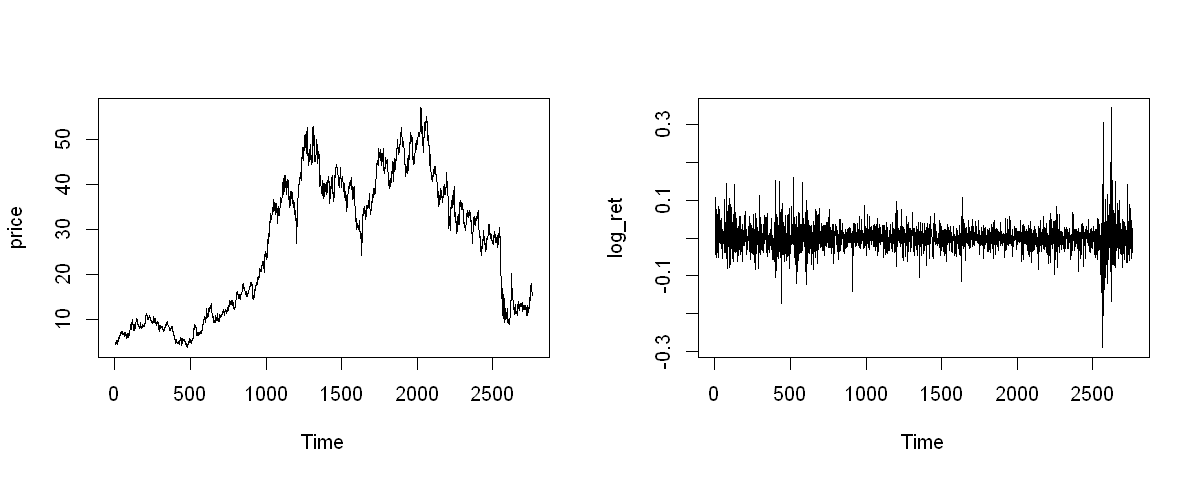

In [6]:
options(repr.plot.width=10, repr.plot.height=4)
par(mfrow = c(1,2))
ts.plot(price)
ts.plot(log_ret)

**Are our data stationary?** 

Let's plot the ACF and PACF and check formally by Augmented Dickey-Fuller test 

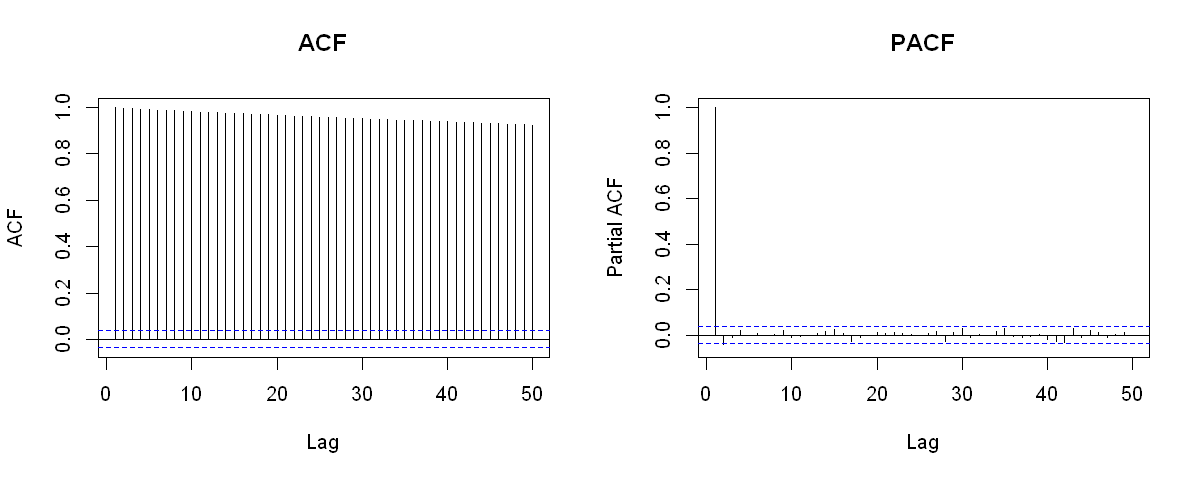

In [7]:
par(mfrow = c(1,2))
Acf(price, lag.max = 50, main = "ACF")
Pacf(price, lag.max = 50, main = "PACF")

In [8]:
tseries::adf.test(price)


	Augmented Dickey-Fuller Test

data:  price
Dickey-Fuller = -0.87988, Lag order = 14, p-value = 0.9545
alternative hypothesis: stationary


Our data are definitely not stationary $\rightarrow$ we create returns by taking logaritmic first differences

**Are returns stationary?** 


Warning message in tseries::adf.test(log_ret):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  log_ret
Dickey-Fuller = -13.619, Lag order = 14, p-value = 0.01
alternative hypothesis: stationary


KPSS Unit Root Test 
alternative: nonstationary 
 
Type 1: no drift no trend 
 lag stat p.value
  12 0.83     0.1
----- 
 Type 2: with drift no trend 
 lag  stat p.value
  12 0.351  0.0984
----- 
 Type 1: with drift and trend 
 lag   stat p.value
  12 0.0413     0.1
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


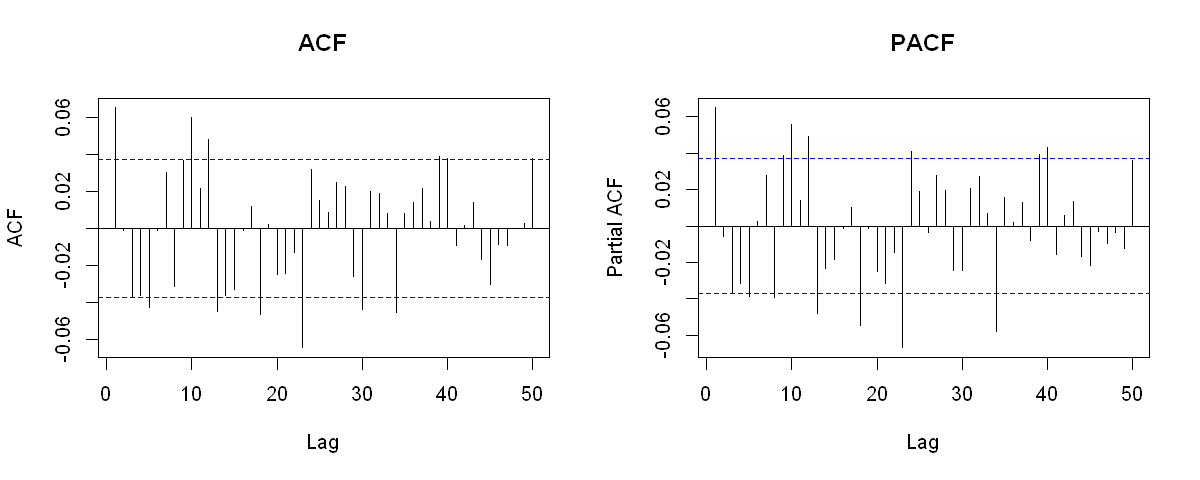

In [9]:
# ACF PACF plots
par(mfrow = c(1,2))
Acf(log_ret, lag.max = 50, main = "ACF")
Pacf(log_ret, lag.max = 50, main = "PACF")

#ADF test
tseries::adf.test(log_ret)

#KPSS test
kpss.test(log_ret)

In [10]:
#?adf.test
#?kpss.test

The log returns are stationary so we can use them further in the ARIMA analysis.

## Select the mean model

Series: log_ret 
ARIMA(1,0,0) with zero mean 

Coefficients:
         ar1
      0.0653
s.e.  0.0190

sigma^2 estimated as 0.001092:  log likelihood=5507.22
AIC=-11010.44   AICc=-11010.44   BIC=-10998.59


	Ljung-Box test

data:  Residuals from ARIMA(1,0,0) with zero mean
Q* = 29.579, df = 9, p-value = 0.0005172

Model df: 1.   Total lags used: 10



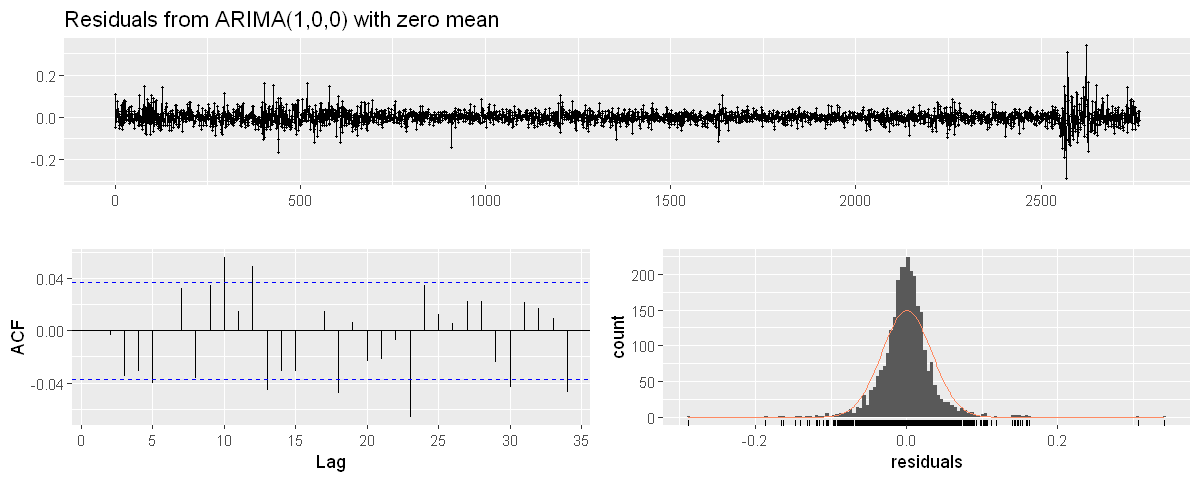

In [11]:
# choose the best model based on the IC
(fit_auto <- auto.arima(log_ret, ic = c("bic"), stationary = TRUE))
checkresiduals(fit_auto)
# AIC and BIC both select ar(1)

We use the Ljung-Box test to verify if the ACF at first 20 lags is jointly equal to zero

In [12]:
Box.test(fit_auto$residuals, lag = 20, type = c("Ljung-Box"))
# null is rejected for now - significant autocorrelation present


	Box-Ljung test

data:  fit_auto$residuals
X-squared = 56.982, df = 20, p-value = 2.065e-05


In [13]:
#?Box.test

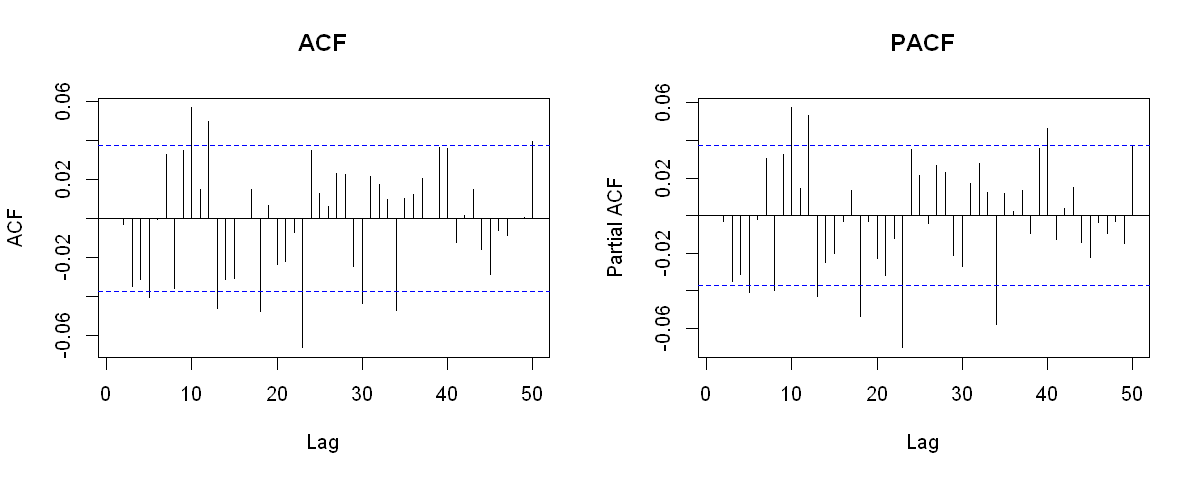

In [14]:
par(mfrow = c(1,2))
Acf(fit_auto$residuals, lag.max = 50, main = "ACF")
Pacf(fit_auto$residuals, lag.max = 50, main = "PACF")

**Residual diagnostics**
- there is visible heteroskedasticity in the residuals (plot of residuals above)
- ARIMA(1,0,0) seems like a good candidate for the mean equation. There is still some linear dependency in the residuals but this may be because of the heteroskedasticity.
- let's check squared residuals for dependence.

In [15]:
#str(fit_auto)

In [16]:
resid <- fit_auto$residuals
resid_sqrd <- resid^2 # create squared residuals

First we check ACF and PACF of the squared residuals and we check for any dependence

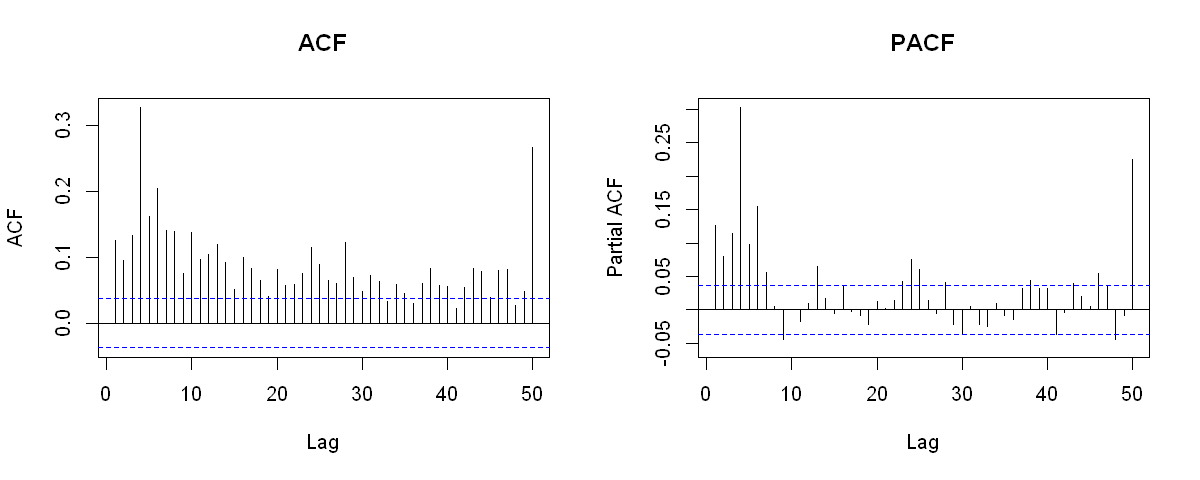

In [17]:
par(mfrow = c(1,2))
Acf(resid_sqrd, lag.max = 50, main = "ACF")
Pacf(resid_sqrd, lag.max = 50, main = "PACF")

ARCH heteroscedasticity test for residuals 
alternative: heteroscedastic 

Portmanteau-Q test: 
     order   PQ p.value
[1,]     4  417       0
[2,]     8  716       0
[3,]    12  842       0
[4,]    16  942       0
[5,]    20  997       0
[6,]    24 1069       0
Lagrange-Multiplier test: 
     order   LM p.value
[1,]     4 5685       0
[2,]     8 1154       0
[3,]    12  758       0
[4,]    16  555       0
[5,]    20  440       0
[6,]    24  363       0


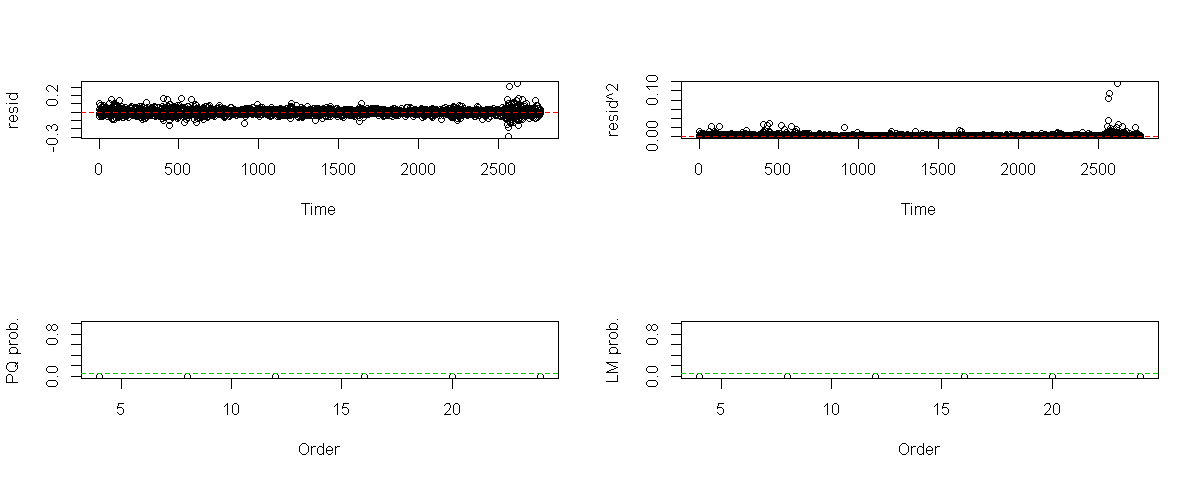

In [18]:
arch.test(arima(log_ret,order = c(1,0,0))) # for this function, we need to provide fitted arima model (auto.arima not accepted)

In [19]:
#?arch.test

Let's try other package and check our results

In [20]:
ArchTest(resid, lags = 12, demean = FALSE) #this function allows us to provide time series instead of fitted arima model


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  resid
Chi-squared = 435.41, df = 12, p-value < 2.2e-16


In [21]:
#?ArchTest

Now we can be sure that there are ARCH/GARCH effects present in our data.

## GARCH modelling
From ACF and PACF of squared residuals from ARIMA(0,0,0) and from ARCH-LM test we can see, that there are further dependencies in the data, thus we will model them by allowing for heteroskedasticity:
- ARCH, and GARCH models

ARCH and GARCH is able to model all the empirically found properties of stock market returns as:
- excess volatility
- volatility clusters
- fat tails which tells us that there is greater probability of unexpected events


### ARIMA(1,0,0)-GARCH(1,1)

In [22]:
# specify the model that we want to estimate
model_specification <- ugarchspec(mean.model = list(armaOrder = c(1, 0), include.mean = TRUE), 
                      variance.model = list(garchOrder = c(1, 1)))

# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)
#infocriteria(fit)

# explore the results
#coef(fit) # estimated parameters
fit



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000585    0.000509   1.1491 0.250529
ar1     0.035142    0.020193   1.7403 0.081811
omega   0.000012    0.000002   5.5387 0.000000
alpha1  0.050495    0.001319  38.2834 0.000000
beta1   0.937108    0.005185 180.7392 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000585    0.000565   1.0364 0.300020
ar1     0.035142    0.020255   1.7350 0.082746
omega   0.000012    0.000008   1.5327 0.125356
alpha1  0.050495    0.011515   4.3852 0.000012
beta1   0.937108    0.009604  97.5697 0.000000

LogLikelihood : 5921.135 

Information Criteria
------------------------------------
                

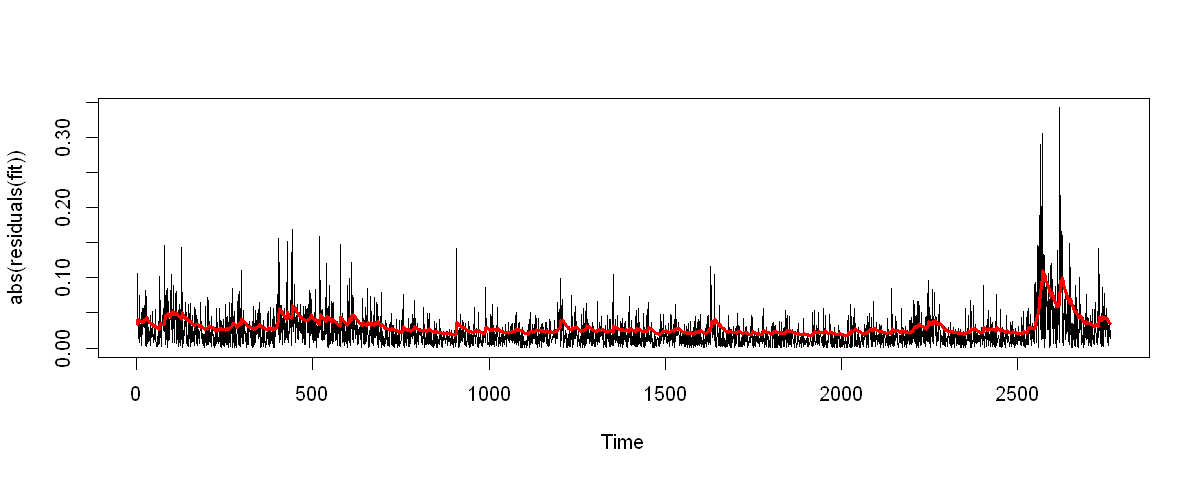

In [23]:
#plot.ts(abs(log_ret))
plot.ts(abs(residuals(fit))) # residuals (after fitting arma model) or log_ret in absolute values
lines(as.numeric(sigma(fit)),col = "red", lwd = 3) 
# plot of the residuals/log returns in absolute value and of estimated conditional standard deviation (volatility)

We can see that we were able to capture dynamics of the returns, but is our model OK?

### Simple model checking

Ljung-Box Test on Standardized Squared Residuals and ARCH LM Tests (in the output from the fit) 

And by visual inspection of standardized residuals and squared standardized residuals

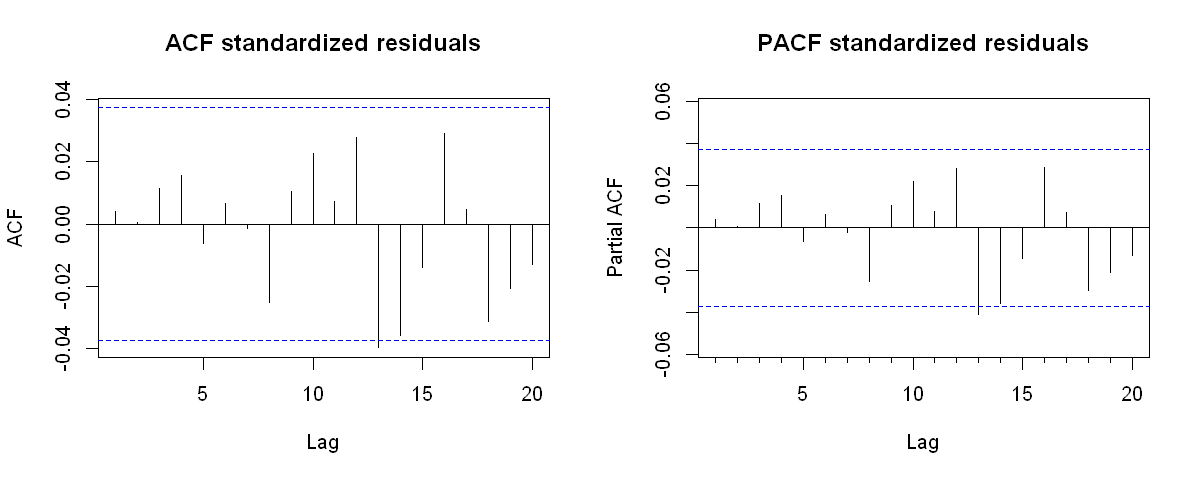

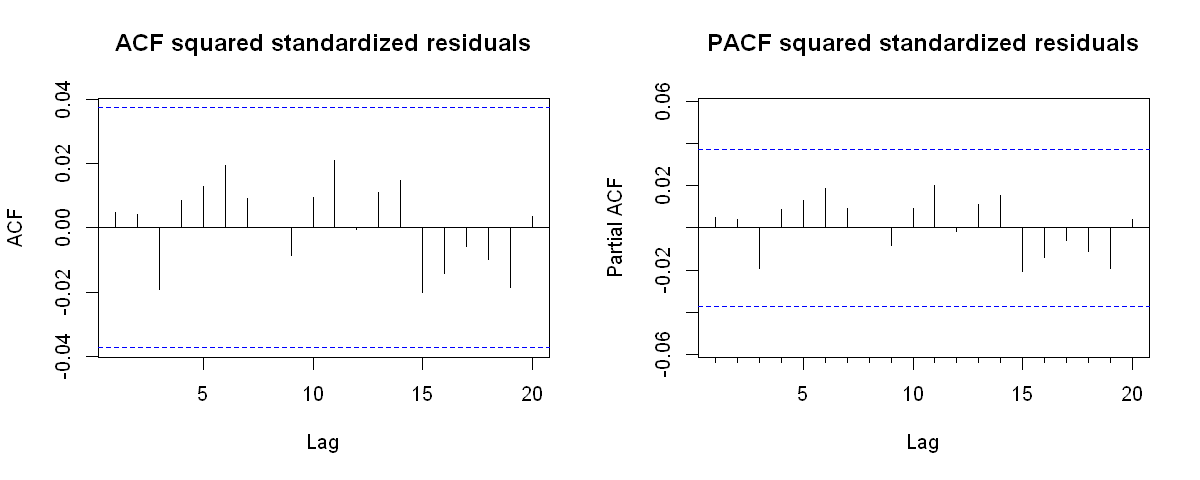

In [24]:
resid_norm <- residuals(fit, standardize = TRUE)
resid_sqrd_norm <- resid_norm^2
par(mfrow = c(1,2))
Acf(resid_norm, lag.max = 20, main="ACF standardized residuals")
Pacf(resid_norm, lag.max = 20, main="PACF standardized residuals")

par(mfrow = c(1,2))
Acf(resid_sqrd_norm, lag.max = 20, main="ACF squared standardized residuals")
Pacf(resid_sqrd_norm, lag.max = 20, main="PACF squared standardized residuals")

In [25]:
# find the best GARCH model based on the AIC/BIC

p_max <- 5
q_max <- 5
aic_min <- Inf
best_p <- 0
best_q <- 0

for (i1 in 1:p_max) {
    for (i2 in 1:q_max) {
        model_specification <- ugarchspec(mean.model = list(armaOrder = c(1, 0), include.mean = TRUE), 
                     variance.model = list(garchOrder = c(i1, i2)))
        fit <- ugarchfit(spec = model_specification, data = log_ret)
        inf_crit <- infocriteria(fit)[2] #1 aic, 2 bic
        aic_min <- ifelse(inf_crit < aic_min, inf_crit, aic_min)
        
        best_p <- ifelse(inf_crit == aic_min, i1, best_p)
        best_q <- ifelse(inf_crit == aic_min, i2, best_q)
    }
}

c(best_p, best_q)

# specify the model that we want to estimate
model_specification <- ugarchspec(mean.model = list(armaOrder = c(1, 0), include.mean = FALSE), 
                     variance.model = list(garchOrder = c(best_p, best_q)))
# estimate the model
fit <- ugarchfit(spec = model_specification, data = resid)

# Explore the results

#show(fit)

# aic suggests arma(1,0)-garch(2,3)
# bic suggests arma(1,0)-garch(1,1)

[1] 1 1

Results of Sign Bias Test (testing presence of leverage effects) suggest there might be some asymmetries

Maybe there are some asymmetries in our data $\Rightarrow$ **TGARCH**

## TGARCH (GJR-GARCH)
We will find that certain assymetries might govern the financial time series.

**Leverage effect:**
- What happends when bad news / good news arrive to the market? - if the effect positive and negative news on volatility the same?
- Does it have the same effect? Or it's assymetric?
- How does it affect our model?

Commonly, returns are asymmetric, and if we do not allow for such asymmetry, we have asymmetric residuals.

Following model allows for assymetries in residuals: GJR-GARCH by Glosten, Jagannathan and Runkle (1993)

$\sigma_t^2=\omega +\alpha_1\varepsilon_{t-1}^2 + \gamma_1\varepsilon_{t-1}^2I_{(\varepsilon_{t-1}<0)} + \beta_1 \sigma_{t-1}^2$

where $I(\cdot)$ denotes indicator function which is 1 for past innovations with negative effect. 

TGARCH sometimes refers to the threshold GARCH model by Zakoian (1994) which has different specification.

### TGARCH

In [26]:
#?ugarchspec

In [27]:
# specify the model that we want to estimate
model_specification <- ugarchspec(mean.model = list(armaOrder = c(1, 0), include.mean = TRUE), 
                      variance.model = list(model = "gjrGARCH", garchOrder = c(1, 1)),
                      distribution.model = "norm")
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)

# explore the results
fit

# based on BIC, GJC-GARCH is better than GARCH


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000181    0.000436   0.41513 0.678043
ar1     0.035739    0.019879   1.79785 0.072200
omega   0.000008    0.000005   1.68274 0.092426
alpha1  0.018442    0.002339   7.88464 0.000000
beta1   0.949600    0.003471 273.57555 0.000000
gamma1  0.047015    0.009056   5.19144 0.000000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000181    0.001922  0.094091 0.925037
ar1     0.035739    0.020331  1.757870 0.078770
omega   0.000008    0.000035  0.237735 0.812087
alpha1  0.018442    0.038477  0.479307 0.631720
beta1   0.949600    0.022892 41.482130 0.000000
gamma1  0.047015    0.023099  2.035388 0

## Other Extensions of GARCH
You can see, that GARCH is just special case of TGARCH, it is TGARCH without assymetries.

We also know other models which can deal with different observations in data. Most important extensions to GARCH are following:
- EGARCH: Exponential GARCH - leverage effect is exponential
- IGARCH: unit-root GARCH, the key is that past squared shocks are persistent
- GARCH-M: GARCH in mean, when the returns are dependent directly on their volatility

### EGARCH (Nelson 1991)
$$
\log _{e}\left(\sigma_{t}^{2}\right)=\omega+\sum_{j=1}^{q}\left(\alpha_{j} z_{t-j}+\gamma_{j}\left(\left|z_{t-j}\right|-E\left|z_{t-j}\right|\right)\right)+\sum_{j=1}^{p} \beta_{j} \log _{e}\left(\sigma_{t-j}^{2}\right)
$$

$z_t = \dfrac{e_t}{\sqrt{\sigma^2_t}}$ is the standardized innovation


$\alpha_j$ captures the sign effect and $\gamma_j$ the size effect


On the left side is log of the conditional variance, leverage effect is expected to be exponential, rather
than quadratic, and forecasts (of variance) will be nonnegative.

the impact will be
asymmetric if $\alpha \neq 0$.

In [28]:
# specify the model that we want to estimate
model_specification <- ugarchspec(mean.model = list(armaOrder = c(1, 0), include.mean = TRUE), 
                      variance.model = list(model = "eGARCH", garchOrder = c(1, 1)))
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)

# explore the results
fit

# BIC lower than for simple garch model


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error    t value Pr(>|t|)
mu      0.000064    0.000470    0.13559 0.892146
ar1     0.044395    0.020937    2.12037 0.033975
omega  -0.045097    0.002733  -16.49934 0.000000
alpha1 -0.048319    0.002559  -18.87893 0.000000
beta1   0.992957    0.000399 2486.98011 0.000000
gamma1  0.087980    0.003494   25.17790 0.000000

Robust Standard Errors:
        Estimate  Std. Error    t value Pr(>|t|)
mu      0.000064    0.000772   0.082462 0.934279
ar1     0.044395    0.024476   1.813811 0.069707
omega  -0.045097    0.010702  -4.214005 0.000025
alpha1 -0.048319    0.017628  -2.741092 0.006124
beta1   0.992957    0.001473 674.153018 0.000000
gamma1  0.087980    0.021306 

### IGARCH
IGARCH models are unit-root GARCH models, their key feature is the assumption of the persistence of conditional volatility.

IGARCH(1,1) is formalized as
$$a_t = \sigma_t\epsilon_t,$$
$$\sigma_t^2= \alpha_0 + \beta_1\sigma_{t-1}^2+(1-\beta_1)a_{t-1}^2$$

This model is stationary, however we should **check for omitted structural breaks** before using iGARCH.

In [29]:
# specify the model that we want to estimate
model_specification <- ugarchspec(mean.model = list(armaOrder = c(1, 0), include.mean = TRUE), 
                      variance.model = list(model = "iGARCH", garchOrder = c(1, 1)))
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)
fit
# Beta is in this case not estimated but calculated - we do not have errors for beta


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: iGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000529    0.000513   1.0323 0.301916
ar1     0.034904    0.020183   1.7294 0.083738
omega   0.000006    0.000002   2.4100 0.015953
alpha1  0.056725    0.008565   6.6227 0.000000
beta1   0.943275          NA       NA       NA

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000529    0.000521  1.01493 0.310139
ar1     0.034904    0.019430  1.79641 0.072430
omega   0.000006    0.000007  0.74983 0.453357
alpha1  0.056725    0.020776  2.73029 0.006328
beta1   0.943275          NA       NA       NA

LogLikelihood : 5913.797 

Information Criteria
------------------------------------
                

# Multivariate GARCH
Generalization of univariate models.

Modeling of covariances and correlations - forecasting.

We allow covariances and correlations to be time-varying.

**Problem?** Very large number of parameters to be estimated $\Rightarrow$ curse of dimensionality problem.

Types of multivariate GARCH models:
- VECH - too many parameters, PD of the conditional variance matrix is not ensured
- diagonal VECH - less parameters, PD of the conditional variance matrix is not ensured
- BEKK - ensures PD of $H_t$
- CCC GARCH
- DCC GARCH - less computationally complex, non linear combination of univariate GARCH
- Asymmetric Generalized DCC
- ...

### Dynamic Conditional Correlation GARCH
The dynamic conditional correlation generalized autoregressive conditional heteroscedasticity (DCC-GARCH) is a widely used multivariate GARCH model in practice. It is a generalization of constant conditional correlation GARCH, with time-varying correlation matrix $R$. The model is defined as

\begin{equation}
H_t=D_t R_t D_t ,
\end{equation}

where $D_t$ is a diagonal matrix of conditional time varying standard deviations, $D_t=diag\left(\sqrt {h_{i,t}}\right)$, and $h_{i,t}$ are univariate GARCH processes, $h_{i,t}=\omega_i+\sum\limits_ {p=1}^{P_i}\alpha_{i,p}r_{i,t-p}^2+\sum\limits_{q=1}^{Q_i} \beta_{i,q} h_{i,t-q}$. The dynamics of the correlation matrix are given by transformation: 
\begin{equation}
R_t=Q_t^{*-1}Q_tQ_t^{*-1} ,
\end{equation}
where $Q_t=\left(1-\sum\limits_{m=1}^{M} \alpha_{m}-\sum\limits_{n=1}^{N}\beta_{n} \right)\bar{Q}+\sum\limits_{m=1}^{M}A_{m}\left(\epsilon_{t-m}\epsilon_{t-m}^T \right)+\sum\limits_{n=1}^{N}B_{n}Q_{t-n}$ ,$\bar{Q}$ is the unconditional covariance matrix of the standardized residuals from the univariate GARCH processes and $Q_t^*=diag\left(\sqrt{q_{ii,t}}\right)$.

In [30]:
data_DCC <- read.table("PX_WIG_2005_2009.txt") # load data Prague stock exchange index and Warsaw index

str(data_DCC)
#ret_DCC <- cbind(diff(log(data_DCC[,1])),diff(log(data_DCC[,2])))
ret_DCC <- apply(data_DCC,2,function(x) diff(log(x), lag = 1))
#ret_DCC==ret_DCC_1
str(ret_DCC)

'data.frame':	964 obs. of  2 variables:
 $ V1: num  1162 1137 1168 1169 1161 ...
 $ V2: num  1970 1980 1998 1989 1985 ...
 num [1:963, 1:2] -0.021574 0.027066 0.000428 -0.006437 0.013428 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "V1" "V2"


In [31]:
#?dccspec

In [32]:
spec <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                   variance.model = list(model = "sGARCH", garchOrder = c(1, 1)))
mspec <- multispec(replicate(2, spec)) # using the same specification for both assets

spec_dcc <- dccspec(mspec, dccOrder = c(1,1), model = c("DCC"))
fit_dcc <- dccfit(spec_dcc, data = ret_DCC)

fit_dcc


*---------------------------------*
*          DCC GARCH Fit          *
*---------------------------------*

Distribution         :  mvnorm
Model                :  DCC(1,1)
No. Parameters       :  11
[VAR GARCH DCC UncQ] : [0+8+2+1]
No. Series           :  2
No. Obs.             :  963
Log-Likelihood       :  5615.921
Av.Log-Likelihood    :  5.83 

Optimal Parameters
-----------------------------------
              Estimate  Std. Error  t value Pr(>|t|)
[V1].mu       0.000863    0.000348   2.4795 0.013158
[V1].omega    0.000005    0.000004   1.1007 0.271033
[V1].alpha1   0.184944    0.029871   6.1914 0.000000
[V1].beta1    0.814056    0.022552  36.0973 0.000000
[V2].mu       0.000756    0.000477   1.5849 0.112990
[V2].omega    0.000005    0.000003   1.4711 0.141268
[V2].alpha1   0.086987    0.017269   5.0370 0.000000
[V2].beta1    0.902128    0.016711  53.9851 0.000000
[Joint]dcca1  0.027135    0.010908   2.4876 0.012860
[Joint]dccb1  0.918637    0.033095  27.7579 0.000000

Informati

 num [1:2, 1:2, 1:963] 1 0.628 0.628 1 1 ...
 - attr(*, "dimnames")=List of 3
  ..$ : chr [1:2] "V1" "V2"
  ..$ : chr [1:2] "V1" "V2"
  ..$ : chr [1:963] "1970-01-02 01:00:00" "1970-01-03 01:00:00" "1970-01-04 01:00:00" "1970-01-05 01:00:00" ...


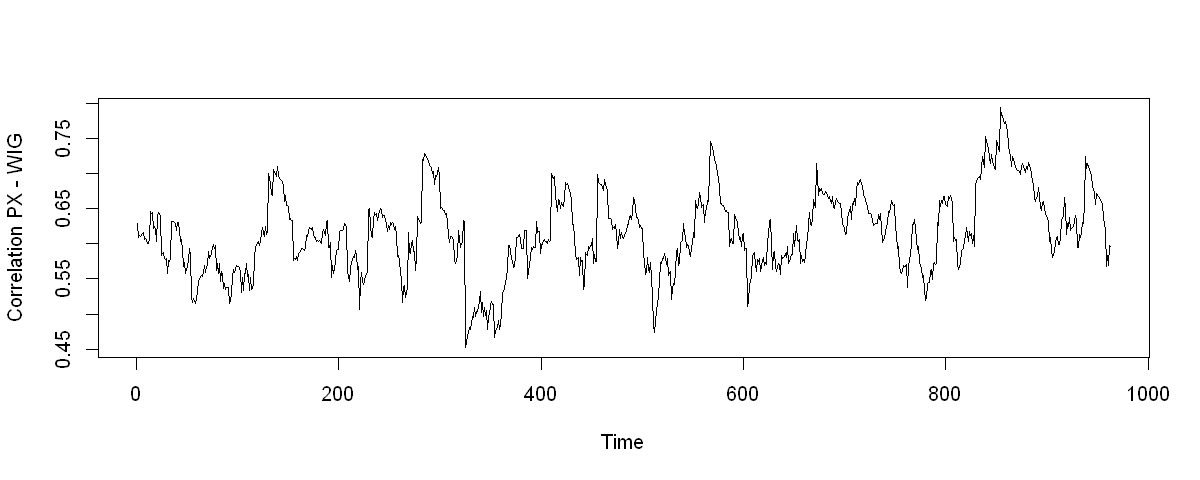

In [33]:
cor_dcc <- rcor(fit_dcc)
str(cor_dcc)
plot.ts(cor_dcc[1,2,], ylab = "Correlation PX - WIG")

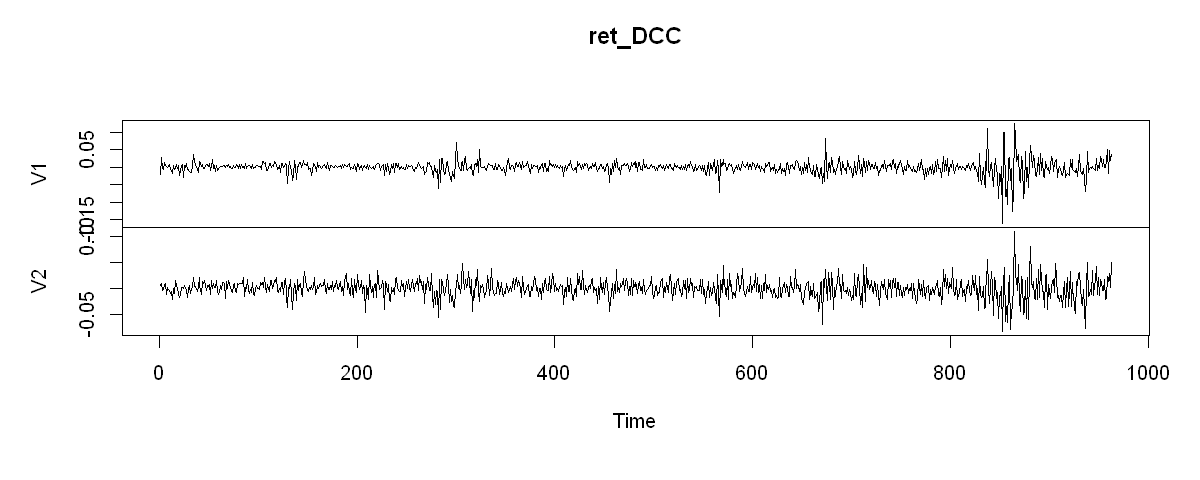

In [34]:
plot.ts(ret_DCC)

'data.frame':	963 obs. of  2 variables:
 $ V1: num  -1.4962 1.3591 0.0954 -0.3896 0.683 ...
 $ V2: num  0.7922 0.031 -0.3918 -0.0098 0.1605 ...


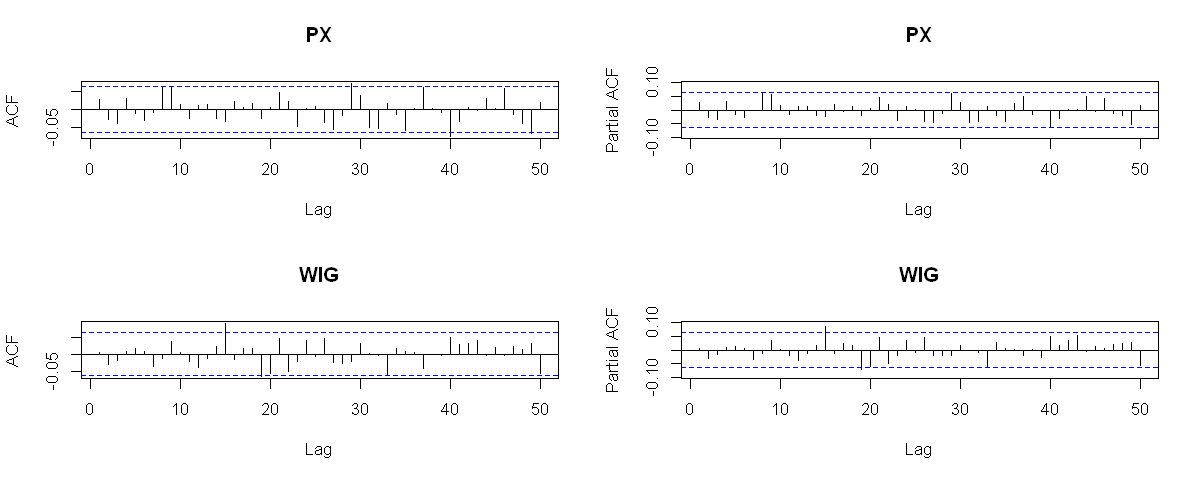

In [35]:
# analysis of residuals: 
resid_dcc <- fit_dcc@mfit$stdresid  # accessing the standardized residuals from the model
resid_dcc = as.data.frame(resid_dcc)
str(resid_dcc)
par(mfrow = c(2,2))
Acf(resid_dcc$V1, lag.max = 50, main = "PX")
Pacf(resid_dcc$V1, lag.max = 50, main = "PX")
Acf(resid_dcc$V2, lag.max = 50, main = "WIG")
Pacf(resid_dcc$V2, lag.max = 50, main = "WIG")

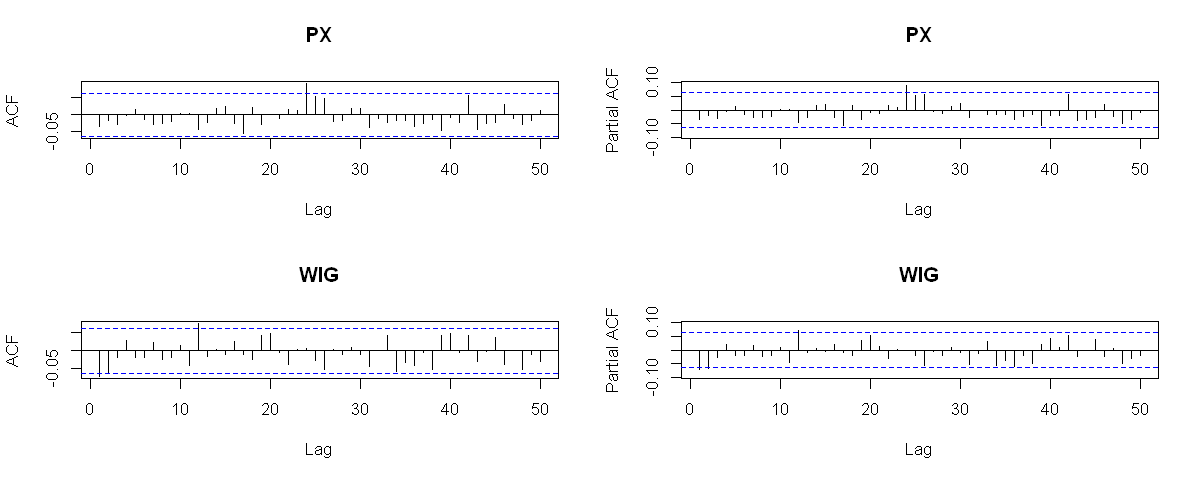

In [36]:
resid_dcc_sqrd<-resid_dcc^2

par(mfrow = c(2,2))
Acf(resid_dcc_sqrd$V1, lag.max = 50, main = "PX")
Pacf(resid_dcc_sqrd$V1, lag.max = 50, main = "PX")
Acf(resid_dcc_sqrd$V2, lag.max = 50, main = "WIG")
Pacf(resid_dcc_sqrd$V2, lag.max = 50, main = "WIG")

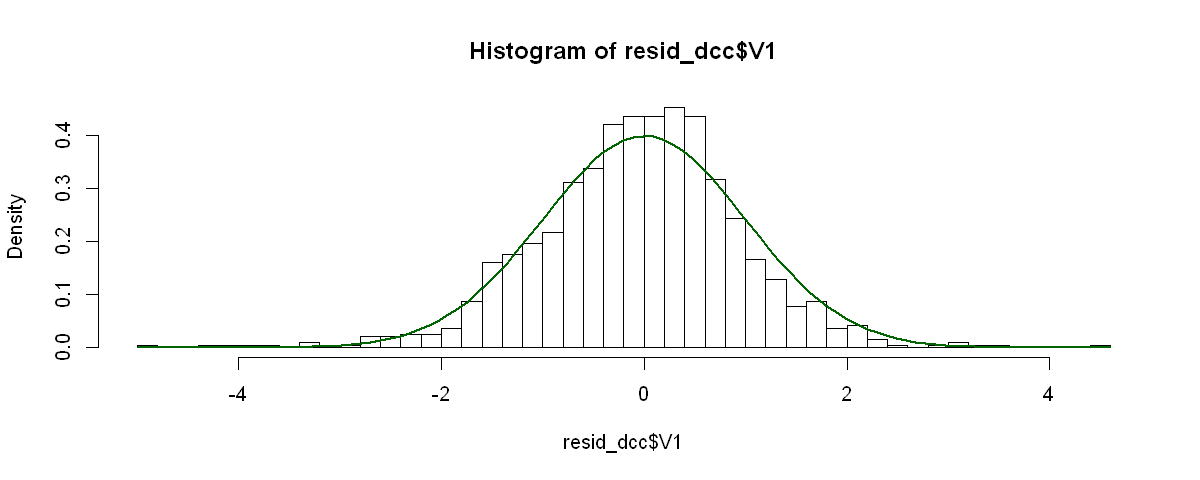

In [37]:
hist(resid_dcc$V1, breaks=50,freq=FALSE)
curve(dnorm(x, mean=0, sd=1), 
      col="darkgreen", lwd=2, add=TRUE, yaxt="n")

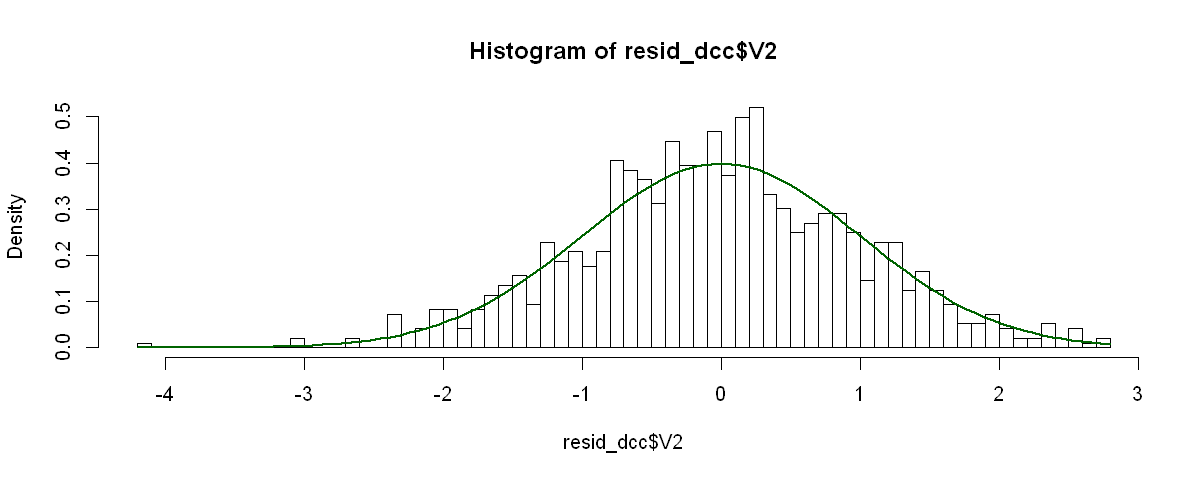

In [38]:
hist(resid_dcc$V2, breaks=50,freq=FALSE)
curve(dnorm(x, mean=0, sd=1), 
      col="darkgreen", lwd=2, add=TRUE, yaxt="n")

# Exercise
- following the Box Jenkins methodology, find a suitable ARMA-GARCH model and estimate it.
- if there is asymmetry, consider GARCH extensions
- interpretation, checking standardized residuals and appropriate tests,...

In [39]:
# EUR-USD exchange rate data
data <- read.csv("EUR=X2.csv", na.strings = c("", "null"))
data$Adj.Close <- as.numeric(as.character(data$Adj.Close))
data$log_returns <- c(NA, diff(log(data$Adj.Close))) 
data <- data[!is.na(data$log_returns), ]
returns = data['log_returns']